In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import einsum
from einops import rearrange
from torch.utils.data import DataLoader, Dataset, RandomSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.functional import mean_squared_error, mean_absolute_error

from transformers import BertModel, BertTokenizer

import numpy as np
import pandas as pd
from tqdm import tqdm
from tdc.multi_pred import DTI
from sklearn.metrics import average_precision_score

molecule_tokenizer = molecule_tokenizer = BertTokenizer.from_pretrained("data/drug/molecule_tokenizer", model_max_length=128)
protein_tokenizer = BertTokenizer.from_pretrained("data/target/protein_tokenizer", do_lower_case=False)

In [2]:
class DualLanguageModelDTI(nn.Module):
    def __init__(self, 
                 molecule_encoder, protein_encoder, hidden_dim=512,
                 molecule_input_dim=128, protein_input_dim=1024):
        super().__init__()
        self.molecule_encoder = molecule_encoder
        self.protein_encoder = protein_encoder
        
        # model freezing without last layer
        for param in self.molecule_encoder.encoder.layer[0:-1].parameters():
            param.requires_grad = False        
        for param in self.protein_encoder.encoder.layer[0:-1].parameters():
            param.requires_grad = False
        
        self.molecule_align = nn.Sequential(
            nn.LayerNorm(molecule_input_dim),
            nn.Linear(molecule_input_dim, hidden_dim)
        )
        
        self.protein_align = nn.Sequential(
            nn.LayerNorm(protein_input_dim),
            nn.Linear(protein_input_dim, hidden_dim)
        )
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc_out = nn.Linear(hidden_dim, 1)
        
    
    def forward(self, molecule_seq, protein_seq):
        encoded_molecule = self.molecule_encoder(**molecule_seq)
        encoded_protein = self.protein_encoder(**protein_seq)
        
        cls_molecule = encoded_molecule.pooler_output
        cls_protein = encoded_protein.pooler_output
        
        cls_molecule = self.molecule_align(cls_molecule)
        cls_protein = self.protein_align(cls_protein)
        
        cls_concat = torch.cat([cls_molecule, cls_protein], dim=1)

        x = F.gelu(self.fc1(cls_concat))
        x = F.gelu(self.fc2(x))
        x = F.gelu(self.fc3(x))
        out = self.fc_out(x)
        
        return out

molecule_bert = BertModel.from_pretrained("weights/molecule_bert")
protein_bert = BertModel.from_pretrained("weights/protein_bert")
dlm_dti = DualLanguageModelDTI(molecule_bert, protein_bert)

Some weights of BertModel were not initialized from the model checkpoint at weights/molecule_bert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at weights/protein_bert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
class DTI_prediction(pl.LightningModule):
    def __init__(self, dlm_dti):
        super().__init__()
        self.model = dlm_dti

        
    def forward(self, molecule_sequence, protein_sequence):
        return self.model(molecule_sequence, protein_sequence)
    
    
    def training_step(self, batch, batch_idx):
        molecule_sequence, protein_sequence, y = batch
        
        y_hat = self(molecule_sequence, protein_sequence).squeeze(-1)        
        loss = F.mse_loss(y_hat, y)
        
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_mae", mean_absolute_error(y_hat, y), on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        molecule_sequence, protein_sequence, y = batch
        
        y_hat = self(molecule_sequence, protein_sequence).squeeze(-1)        
        loss = F.mse_loss(y_hat, y)
        
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("valid_mae", mean_absolute_error(y_hat, y), on_step=False, on_epoch=True, prog_bar=True)
    
    
    def test_step(self, batch, batch_idx):
        molecule_sequence, protein_sequence, y = batch
        
        y_hat = self(molecule_sequence, protein_sequence).squeeze(-1)        
        loss = F.mse_loss(y_hat, y)
        
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_mae", mean_absolute_error(y_hat, y), on_step=False, on_epoch=True, prog_bar=True)
    
    
    def predict_step(self, batch, batch_idx):
        molecule_sequence, protein_sequence, y = batch
        
        y_hat = self(molecule_sequence, protein_sequence).squeeze(-1)        
        
        return y_hat

    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    
dti_regressor = DTI_prediction(dlm_dti)
ckpt_fname = "dlm_dti-epoch=194-valid_loss=0.2036-valid_mae=0.2368.ckpt"
dti_regressor = dti_regressor.load_from_checkpoint("weights/dlm_dti_davis_512/" + ckpt_fname, dlm_dti=dlm_dti)

trainer = pl.Trainer(max_epochs=1, accelerator="cpu", enable_progress_bar=True)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
from rdkit import Chem

def encode_sequences(molecule, protein):
    canonical_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(molecule))
    
    molecule = molecule_tokenizer(" ".join(canonical_smiles), 
                                  max_length=100, truncation=True,
                                  return_tensors="pt")

    protein = protein_tokenizer(" ".join(protein), 
                                max_length=512, truncation=True,
                                return_tensors="pt")
    
    return molecule, protein


def predict(molecule, protein, dti_regressor):
    molecule, protein = encode_sequences(molecule, protein)
    
    dti_regressor.model.eval()
    dti_regressor.model.to("cuda")
    affinity_score = dti_regressor.model(molecule.to("cuda"), protein.to("cuda"))
    embedding = dti_regressor.model.molecule_encoder(**molecule).pooler_output
    
    return affinity_score.to("cpu"), embedding.to("cpu")


def flatten(data):
    flat_list = []
    for d in data:
        flat_list.append(d[0])
        
    return flat_list


def get_features(data, target_sequence, dti_regressor):
    from tqdm import tqdm
    affinity_scores = []
    embeddings = []
    
    for idx in tqdm(range(len(data))):
        affinity_score, embedding = predict(data[idx], target_sequence, dti_regressor)        
        affinity_scores.append(affinity_score.squeeze(0).detach().numpy().tolist())
        embeddings.append(embedding.squeeze(0).detach().numpy().tolist())
        
    affinity_scores = np.array(affinity_scores)
    embeddings = np.array(embeddings)
    
    return affinity_scores, embeddings 
    

In [5]:
VEGFR2 = "MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKANTTLQITCRGQRDLDWLWPNNQSGSEQRVEVTECSDGLFCKTLTIPKVIGNDTGAYKCFYRETDLASVIYVYVQDYRSPFIASVSDQHGVVYITENKNKTVVIPCLGSISNLNVSLCARYPEKRFVPDGNRISWDSKKGFTIPSYMISYAGMVFCEAKINDESYQSIMYIVVVVGYRIYDVVLSPSHGIELSVGEKLVLNCTARTELNVGIDFNWEYPSSKHQHKKLVNRDLKTQSGSEMKKFLSTLTIDGVTRSDQGLYTCAASSGLMTKKNSTFVRVHEKPFVAFGSGMESLVEATVGERVRIPAKYLGYPPPEIKWYKNGIPLESNHTIKAGHVLTIMEVSERDTGNYTVILTNPISKEKQSHVVSLVVYVPPQIGEKSLISPVDSYQYGTTQTLTCTVYAIPPPHHIHWYWQLEEECANEPSQAVSVTNPYPCEEWRSVEDFQGGNKIEVNKNQFALIEGKNKTVSTLVIQAANVSALYKCEAVNKVGRGERVISFHVTRGPEITLQPDMQPTEQESVSLWCTADRSTFENLTWYKLGPQPLPIHVGELPTPVCKNLDTLWKLNATMFSNSTNDILIMELKNASLQDQGDYVCLAQDRKTKKRHCVVRQLTVLERVAPTITGNLENQTTSIGESIEVSCTASGNPPPQIMWFKDNETLVEDSGIVLKDGNRNLTIRRVRKEDEGLYTCQACSVLGCAKVEAFFIIEGAQEKTNLEIIILVGTAVIAMFFWLLLVIILRTVKRANGGELKTGYLSIVMDPDELPLDEHCERLPYDASKWEFPRDRLKLGKPLGRGAFGQVIEADAFGIDKTATCRTVAVKMLKEGATHSEHRALMSELKILIHIGHHLNVVNLLGACTKPGGPLMVIVEFCKFGNLSTYLRSKRNEFVPYKTKGARFRQGKDYVGAIPVDLKRRLDSITSSQSSASSGFVEEKSLSDVEEEEAPEDLYKDFLTLEHLICYSFQVAKGMEFLASRKCIHRDLAARNILLSEKNVVKICDFGLARDIYKDPDYVRKGDARLPLKWMAPETIFDRVYTIQSDVWSFGVLLWEIFSLGASPYPGVKIDEEFCRRLKEGTRMRAPDYTTPEMYQTMLDCWHGEPSQRPTFSELVEHLGNLLQANAQQDGKDYIVLPISETLSMEEDSGLSLPTSPVSCMEEEEVCDPKFHYDNTAGISQYLQNSKRKSRPVSVKTFEDIPLEEPEVKVIPDDNQTDSGMVLASEELKTLEDRTKLSPSFGGMVPSKSRESVASEGSNQTSGYQSGYHSDDTDTTVYSSEEAELLKLIEIGVQTGSTAQILQPDSGTTLSSPPV"

davis = DTI(name="davis")
davis_mols = davis.get_data().loc[:, ["Drug"]].drop_duplicates().values.tolist()
davis_mols = flatten(davis_mols)


Found local copy...
Loading...
Done!


In [6]:
base_affinity_scores, base_embeddings = get_features(davis_mols, VEGFR2, dti_regressor)


100%|███████████████████████████████████████████| 68/68 [00:07<00:00,  8.68it/s]


In [7]:
sorafenib = "CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)c3)cc2)ccn1"
pazopanib = "Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S(N)(=O)=O"
sunitinib = "CCN(CC)CCNC(=O)C1=C(C)NC(\C=C2/C(=O)NC3=C2C=C(F)C=C3)=C1C"
axitinib = "CNC(=O)C1=C(SC2=CC=C3C(NN=C3\C=C\C3=CC=CC=N3)=C2)C=CC=C1"
regorafenib = "CNC(=O)C1=CC(OC2=CC(F)=C(NC(=O)NC3=CC=C(Cl)C(=C3)C(F)(F)F)C=C2)=CC=N1"
nintendanib = "COC(=O)C1=CC=C2C(NC(=O)\C2=C(/NC2=CC=C(C=C2)N(C)C(=O)CN2CCN(C)CC2)C2=CC=CC=C2)=C1"

lenvatinib = "COC1=C(C=C2C(OC3=CC=C(NC(=O)NC4CC4)C(Cl)=C3)=CC=NC2=C1)C(N)=O"
midostaurin = "CO[C@@H]1[C@@H](C[C@H]2O[C@]1(C)N1C3=C(C=CC=C3)C3=C1C1=C(C4=C(C=CC=C4)N21)C1=C3CNC1=O)N(C)C(=O)C1=CC=CC=C1"
cabozantinib = "COC1=CC2=C(C=C1OC)C(OC1=CC=C(NC(=O)C3(CC3)C(=O)NC3=CC=C(F)C=C3)C=C1)=CC=N2"
ripretinib = "CCN1C(=O)C(=CC2=C1C=C(NC)N=C2)C1=C(Br)C=C(F)C(NC(=O)NC2=CC=CC=C2)=C1"
tivozanib = "COC1=C(OC)C=C2C(OC3=CC(Cl)=C(NC(=O)NC4=NOC(C)=C4)C=C3)=CC=NC2=C1"

case_studies = [sorafenib, pazopanib, sunitinib, axitinib, regorafenib, nintendanib, lenvatinib, midostaurin, cabozantinib, ripretinib, tivozanib]
case_study_affinity_socres, case_study_embeddings = get_features(case_studies, VEGFR2, dti_regressor)
case_study_labels = [1 if d >= 7 else 0 for d in case_study_affinity_socres]


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 17.36it/s]


In [8]:
for i in zip(["Sorafenib", "Pazopanib", "Sunitinib", "Axitinib", "Regorafenib", "Nintendanib", "Lenvatinib", "Midostaurin", "Cabozantinib", "Ripretinib", "Tivozanib"], case_study_affinity_socres.round(4)):
    print(i)

('Sorafenib', array([7.1919]))
('Pazopanib', array([7.8032]))
('Sunitinib', array([8.6081]))
('Axitinib', array([7.1515]))
('Regorafenib', array([7.1732]))
('Nintendanib', array([8.4585]))
('Lenvatinib', array([5.0297]))
('Midostaurin', array([5.1741]))
('Cabozantinib', array([5.0941]))
('Ripretinib', array([5.0092]))
('Tivozanib', array([5.0658]))


In [12]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

def tanimoto_calc(smi1, smi2):
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 4, nBits=2048)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 4, nBits=2048)
    s = round(DataStructs.TanimotoSimilarity(fp1,fp2), 4)
    return s

mols = ["Sorafenib", "Pazopanib", "Sunitinib", "Axitinib", "Regorafenib", "Nintendanib", "Lenvatinib", "Midostaurin", "Cabozantinib", "Ripretinib", "Tivozanib"]
results = []

for i, a in enumerate(case_studies):
    result = []
    for j, b in enumerate(case_studies):
        result.append(tanimoto_calc(a, b))
    results.append(result)
        
results = np.array(results)

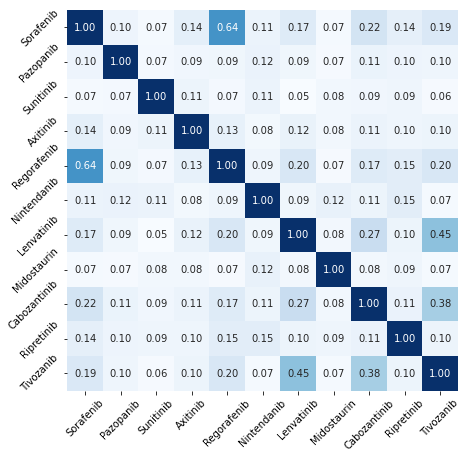

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 7))
sns.heatmap(results, annot=True, fmt=".2f", cbar=False, cmap="Blues")
plt.xticks(np.arange(0.5, len(mols), 1), mols, rotation=45)
plt.yticks(np.arange(0.5, len(mols), 1), mols, rotation=45)

plt.savefig("figure_3.png", dpi=300)
plt.show()

In [32]:
import pickle

with open("data/drug/find_candidates.pkl", "rb") as f:
    candidates_affinity_scores = pickle.load(f)
    
with open("data/drug/chem_qed_filtered_09.txt", "r") as f:
    candidates = f.readlines()
    
candidates_list = []

for line in candidates_affinity_scores:
    for affinity_score, index in zip(line[0], line[1]):
        candidates_list.append([index, affinity_score.numpy().tolist()])
        
candidates_list = pd.DataFrame(candidates_list, columns=['index', 'affinity_score'])
candidates_list = candidates_list.sort_values('affinity_score', ascending=False).reset_index(drop=True)

candidates = np.array([c.rstrip() for c in candidates])
highest = candidates[candidates_list.head(5000)['index'].values]
highest = highest.tolist()

candidates_affinity_socres, candidates_embeddings = get_features(highest, VEGFR2, dti_regressor)


100%|███████████████████████████████████████| 5000/5000 [05:02<00:00, 16.54it/s]


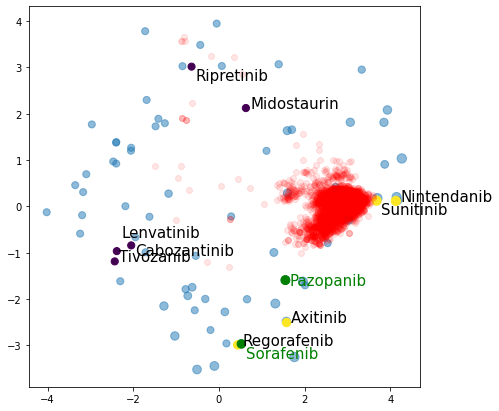

In [34]:
from sklearn.decomposition import PCA

scale_factor = 10

pca = PCA(n_components=2).fit(base_embeddings)
base_pca = pca.transform(base_embeddings)

plt.figure(figsize=(7, 7))
plt.scatter(base_pca[:, 0], base_pca[:, 1], s=base_affinity_scores * scale_factor, alpha=0.5)

case_pca = pca.transform(case_study_embeddings)
plt.scatter(case_pca[2:, 0], case_pca[2:, 1], s=case_study_affinity_socres[2:] * scale_factor, c=case_study_labels[2:])
plt.scatter(case_pca[:2, 0], case_pca[:2, 1], s=case_study_affinity_socres[:2] * scale_factor, c="green")

for i, label in enumerate(["Sorafenib", "Pazopanib", "Sunitinib", "Axitinib", "Regorafenib", "Nintendanib", "Lenvatinib", "Midostaurin", "Cabozantinib", "Ripretinib", "Tivozanib"]):
    
    if label in ["Cabozantinib"]:
        plt.annotate(label, (case_pca[i, 0] + 0.1, case_pca[i, 1] - 0.2), fontsize=15, alpha=1)
    elif label in ["Pazopanib"]:
        plt.annotate(label, (case_pca[i, 0] + 0.1, case_pca[i, 1] - 0.1), fontsize=15, alpha=1, color="green")
    elif label in ["Lenvatinib"]:
        plt.annotate(label, (case_pca[i, 0] + 0.1, case_pca[i, 1] + 0.3), fontsize=15, alpha=1)
    elif label in ["Sunitinib", "Ripretinib"]:
        plt.annotate(label, (case_pca[i, 0] + 0.1, case_pca[i, 1] - 0.3), fontsize=15, alpha=1)
    elif label in ["Sorafenib"]:
        plt.annotate(label, (case_pca[i, 0] + 0.1, case_pca[i, 1] - 0.3), fontsize=15, alpha=1, color="green")
    else:    
        plt.annotate(label, (case_pca[i, 0] + 0.1, case_pca[i, 1]), fontsize=15, alpha=1)
    
candi_pca = pca.transform(candidates_embeddings)
plt.scatter(candi_pca[:, 0], candi_pca[:, 1], alpha=0.1, c="red")
plt.savefig("figure_2.png", dpi=300)

plt.show()

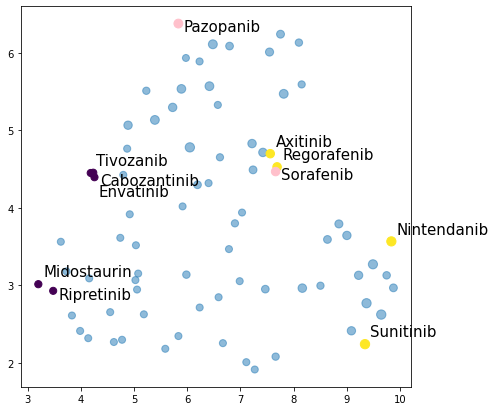

In [86]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

scale_factor = 10

trans = umap.UMAP(n_neighbors=5, random_state=42).fit(base_embeddings)
plt.figure(figsize=(7, 7))
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s=base_affinity_scores * scale_factor, alpha=0.5)

case_study_embeddings_trans = trans.transform(case_study_embeddings)
plt.scatter(case_study_embeddings_trans[2:, 0], case_study_embeddings_trans[2:, 1], s=case_study_affinity_socres[2:] * scale_factor, c=case_study_labels[2:])

plt.scatter(case_study_embeddings_trans[:2, 0], case_study_embeddings_trans[:2, 1], s=case_study_affinity_socres[:2] * scale_factor, c="pink")

# candidates_embeddings_trans = trans.transform(candidates_embeddings)
# plt.scatter(candidates_embeddings_trans[:, 0], candidates_embeddings_trans[:, 1], s=candidates_affinity_socres * scale_factor, alpha=0.05, c="red")

for i, label in enumerate(["Sorafenib", "Pazopanib", "Sunitinib", "Axitinib", "Regorafenib", "Nintendanib", "Midostaurin", "Cabozantinib", "Envatinib", "Ripretinib", "Tivozanib"]):
    if label in ["Sorafenib", "Pazopanib", "Ripretinib", "Cabozantinib"]:
        plt.annotate(label, (case_study_embeddings_trans[i, 0] + 0.1, case_study_embeddings_trans[i, 1] - 0.1), fontsize=15, alpha=1)
    elif label in ["Envatinib"]:
        plt.annotate(label, (case_study_embeddings_trans[i, 0] + 0.1, case_study_embeddings_trans[i, 1] - 0.3), fontsize=15, alpha=1)
    else:    
        plt.annotate(label, (case_study_embeddings_trans[i, 0] + 0.1, case_study_embeddings_trans[i, 1] + 0.1), fontsize=15, alpha=1)
    
    
plt.show()


In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

scale_factor = 10

trans = umap.UMAP(n_neighbors=5, random_state=42).fit(base_embeddings)
plt.figure(figsize=(7, 7))

case_study_embeddings_trans = trans.transform(case_study_embeddings)
plt.scatter(case_study_embeddings_trans[2:, 0], case_study_embeddings_trans[2:, 1], s=case_study_affinity_socres[2:] * scale_factor, c=case_study_labels[2:])

plt.scatter(case_study_embeddings_trans[:2, 0], case_study_embeddings_trans[:2, 1], s=case_study_affinity_socres[:2] * scale_factor, c="pink")

candidates_embeddings_trans = trans.transform(candidates_embeddings)
plt.scatter(candidates_embeddings_trans[:, 0], candidates_embeddings_trans[:, 1], s=candidates_affinity_socres * scale_factor, alpha=0.05, c="red")

for i, label in enumerate(["Sorafenib", "Pazopanib", "Sunitinib", "Axitinib", "Regorafenib", "Nintendanib", "Midostaurin", "Cabozantinib", "Envatinib", "Ripretinib", "Tivozanib"]):
    if label in ["Sorafenib", "Pazopanib", "Ripretinib", "Cabozantinib"]:
        plt.annotate(label, (case_study_embeddings_trans[i, 0] + 0.1, case_study_embeddings_trans[i, 1] - 0.1), fontsize=15, alpha=1)
    elif label in ["Envatinib"]:
        plt.annotate(label, (case_study_embeddings_trans[i, 0] + 0.1, case_study_embeddings_trans[i, 1] - 0.3), fontsize=15, alpha=1)
    else:    
        plt.annotate(label, (case_study_embeddings_trans[i, 0] + 0.1, case_study_embeddings_trans[i, 1] + 0.1), fontsize=15, alpha=1)   
        
plt.show()

In [36]:
candidates_list = pd.DataFrame(candidates_list, columns=['index', 'affinity_score'])
candidates_list = candidates_list.sort_values('affinity_score', ascending=False).reset_index(drop=True)

candidates = np.array([c.rstrip() for c in candidates])
highest = candidates[candidates_list.head(5000)['index'].values]

,index,affinity_score
0,5176296,8.627394
1,5176294,8.620035
2,7338740,8.618099
3,4506260,8.616675
4,5176298,8.615673
...,...,...
95,5652636,8.587666
96,3450142,8.587416
97,3574704,8.587049
98,6471774,8.586884


In [45]:
temp = candidates_list.head(5000).values.tolist()

for i, line in enumerate(temp):
    line.append(highest[i])
    
temp = pd.DataFrame(temp, columns=["index", "predicted_affinity_score", "SMILES"])
temp = temp.drop("index", axis=1)
temp = temp.loc[:, ["SMILES", "predicted_affinity_score"]]
temp

,SMILES,predicted_affinity_score
0,CCC(CC)NS(=O)(=O)C1=CC=C(S1)Br,8.627394
1,CCC(CC)NS(=O)(=O)C1=CC=CC=C1Br,8.620035
2,CCC(CC)NC(=O)CC1C2=CC=CC=C2C=CN1C(=O)C,8.618099
3,CCC(CC)NC(=O)N(C)CC1=NC2=CC=CC=C2S1,8.616675
4,CCC(CC)NS(=O)(=O)C1=CC2=C(CCCC2)C=C1,8.615673
...,...,...
4995,CCN(C)C1=NC(=C(C(=O)N1)C)NC2=C(C=C(C=C2C)C#N)C,8.467104
4996,CCN(CC)C(=O)C1=C(C2=C(C=C1)SC=C2)O,8.467079
4997,CCN(CC)C(=O)NC1=C(N=CC=C1)N2C=NC=N2,8.467031
4998,CCN(CC)C(=O)C1=CNC2=CC(=C(C=C21)OC)OC,8.467028


In [46]:
temp.to_csv("predcited_results.csv")